## Boosting revenue with AB Testing  

<span style="color:blue"> **Project description:** </span> In this project, we work as an analyst in an online store. Together with the marketing
department, we've compiled a list of hypotheses that may help boost
revenue. We need to prioritize these hypotheses, launch an A/B test, and analyze the results.

<span style="color:blue"> **Project goal:** </span> The aim of this project is, on one hand, to prioritize experiments with the help of previously collected scores for nine hypotheses' impact, confidence, effort, and reach parameters; and on the other hand, to analyze the results of a launched A/B test. Our goal is to decide whether to continue or stop the test and interpret the test results. For that purpose, we will compute the group's cumulative convertion rates and cumulative order sizes. We will also test whether the differences between the computed metrics for the groups are statistically significant. 

### Table of Contents

* [Part 1](#step1) Prioritizing Hypothesis
    * [Step 1.1](#step1_1) Preliminary preprocessing
    * [Step 1.2](#step1_2) ICE vs. RICE frameworks
* [Part 2](#step2) A/B Test Analysis
    * [Step 2.1](#step2_1) Data Preprocessing 
    * [Step 2.2](#step2_2) Computing cumulative and relative metrics  
    * [Step 2.3](#step2_3) Outlier analysis in orders and prices
    * [Step 2.4](#step2_4) Statistical significance of the difference in performance between groups
* [Step 3](#step3) General conclusions


<span style="color:blue">**Importing libraries:**</span> First, we import all code libraries and define output style functions we will be using in our project.

In [1]:
# Import libraries and define output style functions.

# Import the pandas library 
#      (url-> https://pandas.pydata.org/).
import pandas as pd

# Import the datetime library 
#      (https://docs.python.org/3/library/datetime.html).
import datetime as dt

# Import pyplot module from matplotlib 
#      (url-> https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.html).
import matplotlib.pyplot as plt

# Import seaborn library
#      (https://seaborn.pydata.org/).
import seaborn as sns

# Import the numpy library 
#      (url-> https://pandas.pydata.org/).
import numpy as np

# Import stats module from scipy  
#      (url-> https://https://www.scipy.org/).
from scipy import stats as st

# Import the warnings and ignore them
#      (url-> https://docs.python.org/3/library/warnings.html).
import warnings
warnings.filterwarnings('ignore')

# Import Markdown and display modules from IPython.display library 
#      (url -> https://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html).
from IPython.display import Markdown, display


In [2]:
# Define printmd() function to print code in blue color.
def printmd(string, color=None):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))
    

<a class="anchor" id="step1"></a> 
### Step 1. Prioritizing Hypothesis: ICE vs. RICE

In this part of the project, we are provided a dataset with 9 hypothesis. We will prioritize these hypothesis first using the ICE framework and then the RICE framework. We will then compare the results of both frameworks.

We have been provided with the following dataset path:
- `/datasets/hypothesis_us.csv`

We are also handed the following information about the fields in this dataset:
- `Hypothesis`: brief descriptions of the hypotheses
- `Reach`: user reach, on a scale of one to ten
- `Impact`: impact on users, on a scale of one to ten
- `Confidence`: confidence in the hypothesis, on a scale of one to ten
- `Effort`: the resources required to test a hypothesis, on a scale of one to ten. The higher the value, the more resource-intensive the test.

Let us first prepare the data for analysis.

####  Step 1.1 Preliminary preprocessing <a class="anchor" id="step1_1"></a>

Here we open the data file and explore the format in which information is stored.

In [3]:
# Read comma-separated values (csv) file into a pandas DataFrame object using pandas.read_csv() method.
# Use try...except to make sure the project runs both on local machine and platform.
try:    # paths on local machine.
    hyp_df = pd.read_csv('hypotheses_us.csv', sep=';') 
except:    # paths on Practicum100 platform.
    hyp_df = pd.read_csv('/datasets/hypotheses_us.csv', sep=';')   


# Assign a name to the Dataframe
hyp_df.name = 'hypotheses'

# Print a concise summary of a DataFrame with pandas.DataFrame.info() method.
printmd("{} dataframe info & content".format(hyp_df.name), color='blue')
hyp_df.info()

# Display the dataframe
display(hyp_df)


<span style='color:blue'>hypotheses dataframe info & content</span>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Effort        9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10
2,Add product recommendation blocks to the store...,8,3,7,3
3,Change the category structure. This will incre...,8,3,3,8
4,Change the background color on the main page. ...,3,1,1,1
5,Add a customer review page. This will increase...,3,2,2,3
6,Show banners with current offers and sales on ...,5,3,8,3
7,Add a subscription form to all the main pages....,10,7,8,5
8,Launch a promotion that gives users discounts ...,1,9,9,5


We see that the dataframe does not contain any `Null` values. We have 4 numerical columns storing data of type `int64`. As expected, these are the `Reach`, `Impact`, `Confidence`, and `Effort` columns. We also observe that the evaluations were scored in a 1 to 10 scale. Technically, we can improve memory usage by downcasting to `uint8`, but since we have only 8 hypothesis, we leave the data type of these numerical columns as they are. The fifth `Hypothesis` column contains the descriptions in string `object` format. By convention, we convert the column names to lower case only letters.

In [4]:
# Change columns to lower case letters.
hyp_df.columns = hyp_df.columns.str.lower()
print(hyp_df.columns)


Index(['hypothesis', 'reach', 'impact', 'confidence', 'effort'], dtype='object')


Let us have the descriptions of the hypotheses fully printed.

In [5]:
printmd("Descriptions of the hypothesis:", color='blue')

for i in range(9):
    print("{}.".format(hyp_df['hypothesis'].iloc[i]))
    print()
    

<span style='color:blue'>Descriptions of the hypothesis:</span>

Add two new channels for attracting traffic. This will bring 30% more users.

Launch your own delivery service. This will shorten delivery time.

Add product recommendation blocks to the store's site. This will increase conversion and average purchase size.

Change the category structure. This will increase conversion since users will find the products they want more quickly.

Change the background color on the main page. This will increase user engagement.

Add a customer review page. This will increase the number of orders.

Show banners with current offers and sales on the main page. This will boost conversion.

Add a subscription form to all the main pages. This will help you compile a mailing list.

Launch a promotion that gives users discounts on their birthdays.



When we had printed earlier the entire dataframe, we could not read the full descriptions of the hypotheses due to display constraints. It is also not very efficient to manipulate a dataframe with space consuming lenghty string objects. For this reason, we propose to number the hypothesis in the order of appearance in the dataframe and store these numbers as integers in the `hypothesis` column. The descriptions can be separately stored in a dictionary as follows.

In [6]:
# Create an empty dictionary with integer keys from 1 to 9
hyp_dict= dict.fromkeys(range(1, 10))

# Fill in the dictionary values with the description through a for loop
for i in range(9):
   hyp_dict[i+1] = hyp_df['hypothesis'].iloc[i]

# Change the content of the hypothesis column to numerical values 
# using the dataframe's indices. The datatype will be automatically inferred.
hyp_df['hypothesis'] = hyp_df.index + 1

# Print a consice summary of the dataframe
hyp_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
hypothesis    9 non-null int64
reach         9 non-null int64
impact        9 non-null int64
confidence    9 non-null int64
effort        9 non-null int64
dtypes: int64(5)
memory usage: 488.0 bytes


We are now ready for analysis.

####  Step 1.2 ICE vs RICE  frameworks<a class="anchor" id="step1_2"></a>

We begin by prioritizing the hypothesis using the ICE framework. Recall that the ICE score is computed with the following formula:
$$
\hbox{ICE_score} = \frac{\hbox{impact_score} \times \hbox{confidence_score}}{\hbox{effort_score}}
$$

In [7]:
# Add ICE score as a new column to the hypothesis dataframe
hyp_df['ICE'] = hyp_df['impact']*hyp_df['confidence']/hyp_df['effort']

# Display the dataframe sorted by the ICE column in descending order.
display(hyp_df.sort_values(by='ICE', ascending=False).reset_index(drop=True))


,hypothesis,reach,impact,confidence,effort,ICE
0,9,1,9,9,5,16.200000
1,1,3,10,8,6,13.333333
2,8,10,7,8,5,11.200000
3,7,5,3,8,3,8.000000
4,3,8,3,7,3,7.000000
5,2,2,5,4,10,2.000000
6,6,3,2,2,3,1.333333
7,4,8,3,3,8,1.125000
8,5,3,1,1,1,1.000000


Here is a summary of our findings for the ICE scores:
- The scores vary from 1 to 16.2. 
- The 9th hypothesis, which got the highest score of 16.2, is the most promising one. It is followed by hypotheses 1, 8, 7, and 3 with the scores 13.3 (approximately), 11.2, 8, 7 in the respective orders.
- The less promising hypothesis, with only 1 point, is hypothesis 5. It is followed by hypotheses 4, 6, 2, whose scores vary between 1 and 2. 

We continue by prioritizing the hypothesis using the RICE framework. It is computed similarly to the ICE score, but with the extra reach factor. The formula is given by:
$$
\hbox{RICE_score} = \frac{\hbox{reach_score} \times \hbox{impact_score} \times \hbox{confidence_score}}{\hbox{effort_score}}
$$
So, let us see how the scores change when the `reach` column is taken into account.

In [8]:
# Add ICE score as a new column to the hypothesis dataframe
hyp_df['RICE'] = hyp_df['reach']*hyp_df['impact']*hyp_df['confidence']/hyp_df['effort']

# Display the dataframe sorted by the RICE column in descending order.
display(hyp_df.sort_values(by='RICE', ascending=False).reset_index(drop=True))


,hypothesis,reach,impact,confidence,effort,ICE,RICE
0,8,10,7,8,5,11.200000,112.0
1,3,8,3,7,3,7.000000,56.0
2,1,3,10,8,6,13.333333,40.0
3,7,5,3,8,3,8.000000,40.0
4,9,1,9,9,5,16.200000,16.2
5,4,8,3,3,8,1.125000,9.0
6,2,2,5,4,10,2.000000,4.0
7,6,3,2,2,3,1.333333,4.0
8,5,3,1,1,1,1.000000,3.0


Here are our findings for the RICE scores:
- The scores vary from 3 to 112. 
- The highest score of 112 corresponds to hypothesis 8. It is followed by hypotheses 3 with 56 points, and hypotheses 1 and 7 with both 40 points. The fifth rank goes to hypothesis 9 with score 16.2. 
- The lowest score of 3 corresponds to hypothesis 5. It is followed by hypotheses 2 and 6, which received both 4 point. The remaining hypothesis 4, got only a slightly better score of 9. 

To help use with the analysis, let us visualize the ICE and RICE scores for the hypotheses.

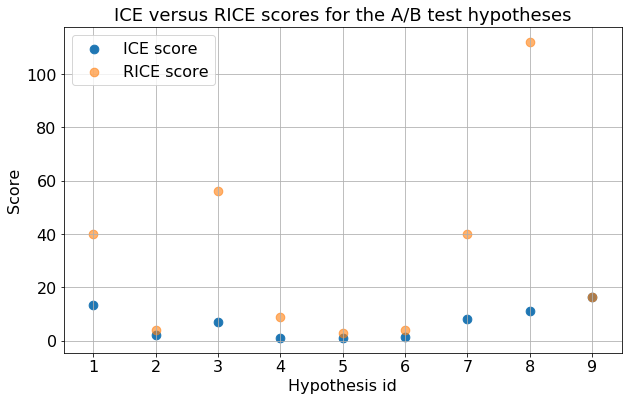

In [9]:
plt.figure(figsize=(10, 6))
plt.scatter(hyp_df['hypothesis'], hyp_df['ICE'], s=75, label='ICE score')
plt.scatter(hyp_df['hypothesis'], hyp_df['RICE'], alpha= 0.6, s=75, label='RICE score')
plt.title('ICE versus RICE scores for the A/B test hypotheses', fontsize=18)
plt.xlabel('Hypothesis id', fontsize=16)
plt.ylabel('Score', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()
plt.legend(fontsize=16)
plt.show()


When we compare the scores obtained from both frameworks, we see that the list of the most promising five hypothesis still consists of hypothesis 9, 1, 8, 7, and 3. However, the ranks of these hypothesis changed considerably from one framework to the other. Let us now describe what happened when we took the reach score into account when computing the final score for the hypothesis:
- When the reach factor came into play, the 8th hypothesis became the most promising one instead of the 9th one. This is not surprising since these hypotheses ICE scores differ by only 5 points, the hypothesis 9 received the lowest reach score of 1 while the hypothesis 8 received the highest reach score of 10. As a multiplicative factor, this created a large discrepency between the RICE scores of these two hypotheses.   
- Hypothesis 3 got the second highest RICE framework taking the rank of the 1st one in the ICE framework. Their scores differed by 2 points in the latter framework. This difference grew slightly in the RICE framework because hypothesis 3 has a reach score of 8 points and hypothesis 1 a reach score of 3.
- Nevertheless, hypothesis 1 took 3rd place (moving one down from 2nd) in the RICE framework. The 3rd place is shared with hypothesis 7 that came 4th in the ICE framework. Hypothesis 9 appeared only at the 5th place (rather than being the most promising one). Only the result for hypothesis 7 did not change in both frameworks, remaining at the 4th place. We also note that the rank of the least promising four hypothesis also changed, except for the lowest scored hypothesis 5. Again all thanks to the fact that the better reach factor of hypothesis 7 compared to hypothesis 1. 
- Among the remaining hypothesis, only the total score of hypothesis 4 quite improved as it has a quite high reach score given by 8 points. Nonetheless, this wasn't enough to bring the hypothesis in the top 5 list, as the hypothesis requires a lot of effort to be tested (with an effort score of 8), which causes its ICE score to be very low to start with. 

**Concluding remarks** In this first part of the project, we worked with a very small dataset containing scores about various factors that could potentially help us rank 9 hypotheses according to their level of importance. 
In practice, testing a hypothesis costs a lot of money and we only have limited resources. By prioritizing the hypotheses before launching A/B tests, we want to ensure that we focus in our tests on achieving maximum growth of the key business metrics.

To identify the most promising hypothesis, we computed the ICE and RICE scores of each hypothesis, ranked them from highest to lowest, and also compared the resulting scores from both frameworks. As the scores of these two frameworks only differ by a multiplicative factor assessing the reach of each hypothesis, the scores of the hypotheses with higher reach factors were boosted considerably more. As a result, even though the top 5 ranked hypotheses did not change in both frameworks, the ranks and relative scores of the top 5 hypothesis did change considerably.

<a class="anchor" id="step2"></a> 
### Step 2. A/B Test Analysis

In this second part of the project, we analyze the results of an A/B test that was carried out.

The test results are located on the following dataset paths:
- `/datasets/orders_us.csv`
- `/datasets/visits_us.csv`

The datasets contain the following columns:
- `orders_us`:
    - `transactionId`: order identifier
    - `visitorId`: identifier of the user who placed the order
    - `date`: of the order
    - `revenue`: from the order
    - `group`: the A/B test group that the user belongs to
    
- `visits_us`:
    - `date`: date
    - `group`: A/B test group
    - `visits`: the number of visits on the date specified in the A/B test group specified

We first need to preprocess the data carefully. There might be mistakes in the original datasets; for example, some of the visitors might have gotten into both group A and group B.

#### Step 2.1 Data Preprocessing <a class="anchor" id="step2_1"></a> 

As usual we read and print an oveview of our datasets.

In [10]:
# Read comma-separated values (csv) file into a pandas DataFrame object using pandas.read_csv() method.
# Use try...except to make sure the project runs both on local machine and platform.
try:    # paths on local machine.
    orders = pd.read_csv('orders_us.csv') 
    visits = pd.read_csv('visits_us.csv') 
except:    # paths on Practicum100 platform.
    orders = pd.read_csv('/datasets/orders_us.csv') 
    visits = pd.read_csv('/datasets/visits_us.csv') 

# Create a tuple from the dataframes.
data = (orders, visits) 

# Assign names to the dataframes
orders.name = 'orders'
visits.name = 'visits'

# Print a concise summary of the dataFrames with pandas.DataFrame.info() method.
for df in data:
    printmd("{}".format(df.name), color='blue')
    display(df.info())
    display(df.head())
    print()
    

<span style='color:blue'>orders</span>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null float64
group            1197 non-null object
dtypes: float64(1), int64(2), object(2)
memory usage: 46.9+ KB


None

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B


<span style='color:blue'>visits</span>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date      62 non-null object
group     62 non-null object
visits    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


From the printed information, we see that there are no null values in the dataframes. However, it is clear that we need to convert the `date` columns in both dataframes to datetime columns (from strings). In addition, if the `group` columns in both dataframes contain only two categories as we expect, we could convert them into category data type. Let us check the unique values of these columns.

In [11]:
for df in data:
    printmd("{} dataframe unique values group values".format(df.name), color='blue')
    display(df['group'].unique())
    

<span style='color:blue'>orders dataframe unique values group values</span>

array(['B', 'A'], dtype=object)

<span style='color:blue'>visits dataframe unique values group values</span>

array(['A', 'B'], dtype=object)

Indeed, we only have group A and group B. So, let us optimize data types.

In [12]:
# Cast the data types of the 'group' columns in both dataframes to category 
# Cast the data types of the 'date' columns in both dataframes to datetime
for df in data:
    df['group'] = df['group'].astype('category')
    df['date'] = df['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d')) 
    
    # Print dataframes' info
    printmd("{}".format(df.name), color='blue')
    df.info()
    

<span style='color:blue'>orders</span>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null datetime64[ns]
revenue          1197 non-null float64
group            1197 non-null category
dtypes: category(1), datetime64[ns](1), float64(1), int64(2)
memory usage: 38.8 KB


<span style='color:blue'>visits</span>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date      62 non-null datetime64[ns]
group     62 non-null category
visits    62 non-null int64
dtypes: category(1), datetime64[ns](1), int64(1)
memory usage: 1.2 KB


Let us next check the content of the columns and if they are consistent accross the two dataframes. 

In [13]:
print("Number of unique transaction ids in 'orders' dataframe:", 
      len(orders['transactionId'].unique()))

print("Number of unique visitor ids in 'orders' dataframe:", 
      len(orders['visitorId'].unique()))


Number of unique transaction ids in 'orders' dataframe: 1197
Number of unique visitor ids in 'orders' dataframe: 1031


As expected, all rows of the `orders` dataframe correspond to orders with unique transaction ids. The number of unique visitors who placed an order is on the other hand slightly smaller, indicating that only a small number of visitors placed more than one order. 

We now check the date range in both datasets.

In [14]:
# Display summary statistics of the 'date' columns via pandas.DataFrame.describe() method
for df in data:
    printmd("{} dataframe summary statistics for the date column".format(df.name), color='blue')
    display(df['date'].describe())
    

<span style='color:blue'>orders dataframe summary statistics for the date column</span>

count                    1197
unique                     31
top       2019-08-05 00:00:00
freq                       48
first     2019-08-01 00:00:00
last      2019-08-31 00:00:00
Name: date, dtype: object

<span style='color:blue'>visits dataframe summary statistics for the date column</span>

count                      62
unique                     31
top       2019-08-02 00:00:00
freq                        2
first     2019-08-01 00:00:00
last      2019-08-31 00:00:00
Name: date, dtype: object

Okay, both dataframes contain data for each day of August 2019.

Now, we move to the revenue column to see if there are any suspicious entries. For that purpose, let us compute summary statistics and plot a histogram. 

count     1197.000000
mean       131.491646
std        603.004729
min          5.000000
25%         20.800000
50%         50.200000
75%        130.400000
max      19920.400000
Name: revenue, dtype: float64

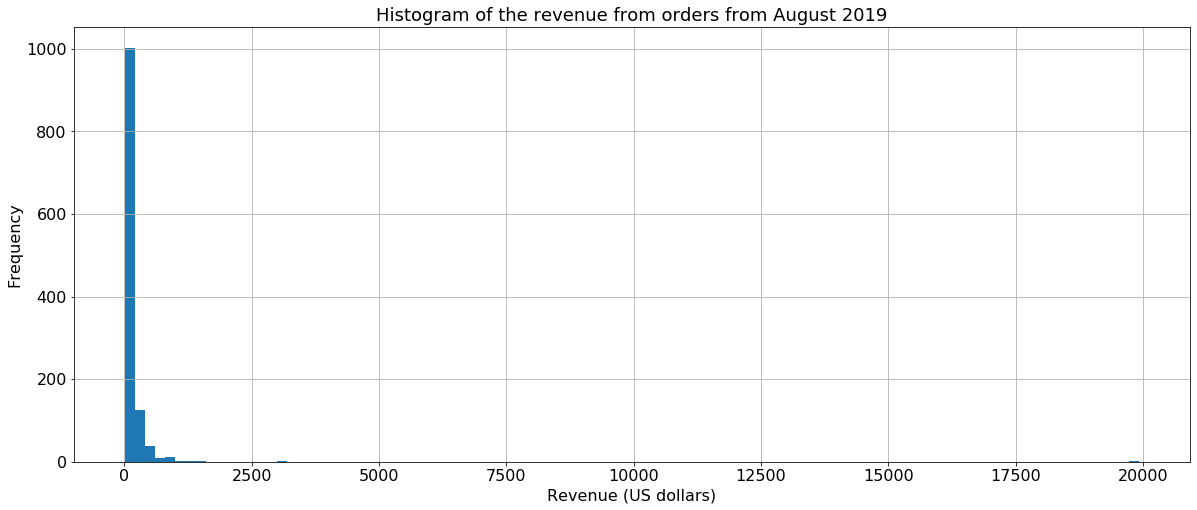

In [15]:
# Display summary statistics of the revenue column 
display(orders['revenue'].describe())

# Create a histogram of the revenue column
plt.figure(figsize=(20, 8))
orders['revenue'].hist(bins=100)
plt.title('Histogram of the revenue from orders from August 2019', fontsize=18)
plt.xlabel('Revenue (US dollars)', fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.yticks(fontsize=16)

plt.show()

# orders.loc[orders['revenue'] == orders['revenue'].max()]
# orders.loc[~(orders['revenue'] == orders['revenue'].max()), 'revenue'].describe()


From the histogram, we clearly see that the revenue from few orders were exceptionally large (around 3000 and 20000 US dollars). These orders caused the average revenue per order to be larger than the median revenue: While the mean is around 131.5 US dollar, the median is around 50 US dollars. Although these orders with exceptionally large revenues likely correspond to statistical outliers in our data, we do not expect them to be erroneous entries. We are not sure about the source of these orders, yet it is possible for instance that busimess customers placed orders with a large number of items.

Next in line, we want to check if visitors were consistently separated into the two groups, i.e., were some of them assigned to both groups by mistake? If so, we should discard them while analysing the test results.

In [16]:
# Count the number of groups each visitor appears in the orders dataframe
group_counts = orders.groupby('visitorId')['group'].nunique().reset_index()

# Filter visitors assigned to more than one group and print the number of such visitors
AB_visitors = group_counts.loc[group_counts['group'] > 1]
print('Number of visitors that were assigned to both groups A and B are:', len(AB_visitors))
# display(AB_visitors)

# Create a Bolean filtering condition to identify the visitors assigned to both groups
# and print the number of orders belonging to these visitors
AB_group_cond = orders['visitorId'].isin(AB_visitors['visitorId'])
print('Number of orders belonging to visitors that were assigned to both groups A and B are:',
      AB_group_cond.sum())
# display(orders.loc[AB_group_cond])

# Create an independent copy of the order dataframe rows removing the visitors assigned to both groups
# and print the info of the new dataframe
orders_cleaned = orders.loc[~AB_group_cond].copy()
orders_cleaned.info()

# Print the number of visitors in each group in the new dataframe
print('Number of visitors (only) in group A is:',
     len(orders_cleaned.loc[orders_cleaned['group']=='A']))
print('Number of visitors (only) in group B is:',
     len(orders_cleaned.loc[orders_cleaned['group']=='B']))


Number of visitors that were assigned to both groups A and B are: 58
Number of orders belonging to visitors that were assigned to both groups A and B are: 181
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1016 non-null int64
visitorId        1016 non-null int64
date             1016 non-null datetime64[ns]
revenue          1016 non-null float64
group            1016 non-null category
dtypes: category(1), datetime64[ns](1), float64(1), int64(2)
memory usage: 40.8 KB
Number of visitors (only) in group A is: 468
Number of visitors (only) in group B is: 548


We found that there were 58 visitors that were assigned to both group A and group B. After discarding the orders from these visitors, we are left with a dataframe containing information about 1016 orders. We also found that 468 of the remaining visitor were assigned to group A and 548 of them to group B. So, each group had approximately 500 visitors. 

Recall that the <code>visits</code> column of the <code>visits</code> dataframe show the number of visits from visitors of both groups. But the counted visitors include those that were assigned to both groups. Since we removed them from the <code>orders</code> dataframe, we also need to substract their counts from the <code>visits</code> dataframe. To do so, we first count for each day of August 2019, the number of orders that were placed by visitors in group A and group B. Then, we substract these counts from the <code>visits</code> dataframe.

Let us make a side note here. We notice that there might be a problem in the name of the <code>visits</code> column of the <code>visits</code> dataframe. It is actually not clear from the column's description whether multiple visits from the same visitor have been counted as one visit or not. Since we do not have raw data on the visits, but only aggregated data, we cannot verify this. So, in theory if a visitor that was assigned to both groups visited the site on a given date 100 times, we should remove 100 from the visit counts and not just 1. In practice, we assume that this is a highly unlikely event and even if not exact the counts are approximately accurate (given we only have 58 visitors assigned to both groups in slightly more than 1000 visitors).

In [17]:
# Group orders dataframe by 'date' and 'group' columns and count the number of orders place by each group
AB_orders_groupby = orders.loc[AB_group_cond].groupby(
    by=['date', 'group'])['transactionId'].count().reset_index()
AB_orders_groupby = AB_orders_groupby.sort_values(by=['date', 'group'])
printmd('Head of dataframe showing the number of orders for each date and group', color='blue')
display(AB_orders_groupby.head())

# Make an independent copy of the visits dataframe and sort its row by date and group
visits_cleaned = visits.copy()
visits_cleaned = visits_cleaned.sort_values(by=['date', 'group']).reset_index()
printmd('Head of dataframe showing the number of visits for each date and group', color='blue')
display(visits_cleaned.head())

# Make a sanity check to ensure we have the same number of rows.
print('The processed visits dataframe contains {} rows.'.format(len(visits_cleaned)))
print('The grouped dataframe from the preprocesse orders dataframe contains {} rows.'.format(len(AB_orders_groupby)))

# Substract the visits from visitors that were assigned to both groups
visits_cleaned['visits'] = visits_cleaned['visits'] - AB_orders_groupby['transactionId']
printmd('Head of resulting cleaned visits dataframe after substraction', color='blue')
display(visits_cleaned.head())


<span style='color:blue'>Head of dataframe showing the number of orders for each date and group</span>

,date,group,transactionId
0,2019-08-01,A,1
1,2019-08-01,B,4
2,2019-08-02,A,1
3,2019-08-02,B,1
4,2019-08-03,B,2


<span style='color:blue'>Head of dataframe showing the number of visits for each date and group</span>

,index,date,group,visits
0,0,2019-08-01,A,719
1,31,2019-08-01,B,713
2,1,2019-08-02,A,619
3,32,2019-08-02,B,581
4,2,2019-08-03,A,507


The processed visits dataframe contains 62 rows.
The grouped dataframe from the preprocesse orders dataframe contains 56 rows.


<span style='color:blue'>Head of resulting cleaned visits dataframe after substraction</span>

,index,date,group,visits
0,0,2019-08-01,A,718.0
1,31,2019-08-01,B,709.0
2,1,2019-08-02,A,618.0
3,32,2019-08-02,B,580.0
4,2,2019-08-03,A,505.0


We cleaned the datasets and are now ready to analyze step by step the results of the A/B test.

#### Step 2.2 Computing cumulative and relative metrics <a class="anchor" id="step2_2"></a> 

In this step we study the following metrics:
- The cumulative revenue by group;
- The cumulative average order size by group;
- The relative difference in cumulative average order size for group B compared with group A;
- The group's daily and cumulative conversion rates, as well as their relative differnce.

We are interested in cumulative metrics, as the values of cumulative metrics do often converge and settle around a particular mean (by the central limit theorem). Plotting them can help us decide whether to continue the test or not.
On the other hand, we plot the relative difference graphs to make the differences between computed metrics more noticeable. 

To compute each cumulative metric, we will first create pivot tables aggregating the appropriate parameter values on each date and for each group, and then, we take cumulative sums. 

**Cumulative revenue by group:** Let us compute and plot the cumulative revenue by day and A/B test group.

group,A,B
date,,
2019-08-01,2266.6,967.2
2019-08-02,3734.9,3535.3
2019-08-03,5550.1,4606.9
2019-08-04,6225.6,6138.5
2019-08-05,7623.6,7587.8
2019-08-06,8292.0,10957.1
2019-08-07,10234.0,14392.7
2019-08-08,11638.8,16772.6
2019-08-09,13734.0,18428.8


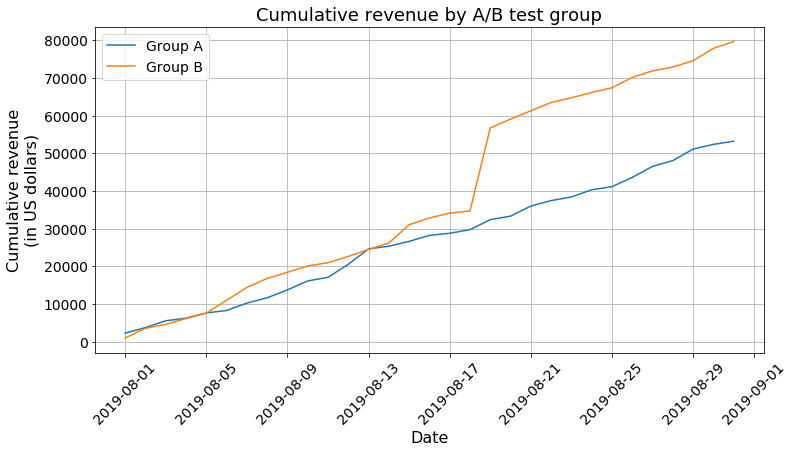

In [18]:
# Create a pivot table to find the total revenue from each group on each date 
rev_pivot = pd.pivot_table(index='date', columns='group', values='revenue', 
            aggfunc='sum' , data=orders_cleaned)
# display(rev_pivot)

# Compute cumulative revenue summing rows of the pivot table via pandas.DataFrame.cumsum() function
cum_rev_pivot = rev_pivot.cumsum()
display(cum_rev_pivot)

# Plot cumulative revenue of each group on the same graph
plt.figure(figsize=(12, 6))

# Plotting the cumulative revenue graph of group A
plt.plot(cum_rev_pivot.index, cum_rev_pivot['A'], label='Group A')

# Plotting the cumulative revenue graph of group B
plt.plot(cum_rev_pivot.index, cum_rev_pivot['B'], label='Group B')

plt.title('Cumulative revenue by A/B test group', fontsize=18)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Cumulative revenue\n(in US dollars)', fontsize=16)
plt.grid()
plt.legend(fontsize=14)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.show()


As a good sign, we observe that the revenue is rising steadily throughout the whole test. We also observe that, at the end of the month, cumulated revenue from group B is approximately 1.6 times larger than group A. In fact, we see that group B sees a big jump in revenue after mid-month (the 19th day to be more precise). After that point onward, the gap between the revenues from group A and group B remains more or less constant. This may be due either to a surge in the number of orders or the presence of very expensive orders from group B. We will later analyze the outliers causing the observed jump.  

**Cumulative average order size by group:** We compute and plot the average order size by group. To compute this metric, we divide the cumulative revenue by the cumulative number of orders. 

group,A,B
date,,
2019-08-01,98.547826,56.894118
2019-08-02,88.926190,88.382500
2019-08-03,84.092424,85.312963
2019-08-04,80.851948,90.272059
2019-08-05,77.006061,85.256180
2019-08-06,72.736842,97.831250
2019-08-07,78.723077,106.612593
2019-08-08,80.825000,106.831847
2019-08-09,88.606452,104.709091


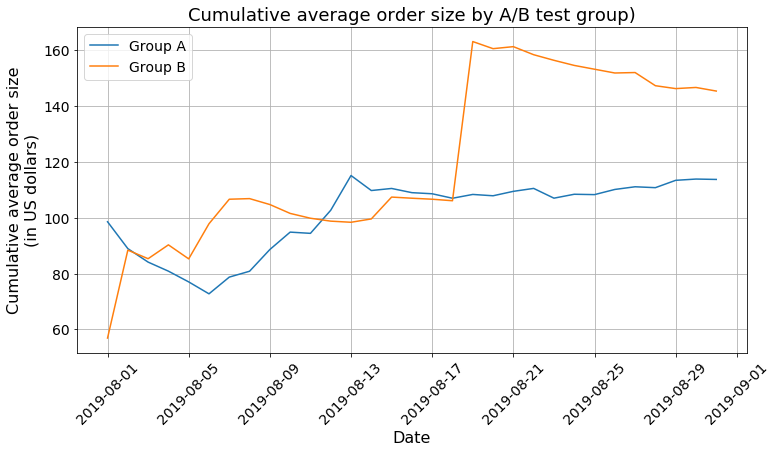

In [19]:
# Create a pivot table to find the total number of orders from each group on each date 
order_count_pivot = pd.pivot_table(index='date', columns='group', 
                                     values='transactionId', aggfunc='count',
                                     data=orders_cleaned)
# display(order_size_pivot)

# Compute cumulative number of orders from the pivot table
cum_order_count_pivot = order_count_pivot.cumsum()
# display(cum_order_size_pivot)

# Compute average order size by taking the ratio of the entris from the cumulative revenue and cumulative order tables
cum_avg_order_size_pivot = cum_rev_pivot/cum_order_count_pivot
display(cum_avg_order_size_pivot)

# Plot average order size of each group on the same graph
plt.figure(figsize=(12, 6))

# Plotting the average order size graph of group A
plt.plot(cum_avg_order_size_pivot.index, cum_avg_order_size_pivot['A'], label='Group A')
# Plotting the average order size graph of group A
plt.plot(cum_avg_order_size_pivot.index, cum_avg_order_size_pivot['B'], label='Group B')

plt.title('Cumulative average order size by A/B test group)', fontsize=18)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Cumulative average order size\n(in US dollars)', fontsize=16)
plt.legend(fontsize=14)
plt.grid()
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.show()


We see that the average order size display a steady behavior by the end of the test for both groups. In particular, it stabilizes for group A and steadily keep decreasing for group B. In the first half of the month, we observe that there was first a drop and then a surge in the average order size of group A. In the second half of the month, the order size of group A showed a relatively flat behavior. As for group B, we observe 3 large surge: one in the first few days of the month, another one after between the 5th and 7th day of the month, and a big jump of close 60 orders more after mid-month (also on the 19th day of the month). Thus, we conclude that the surge in the cumulative revenue that happened on the same day mid-month, also resulted in the surge of the cumulative average order size. This means again that large and/or expensive orders were place on that day. 

**Relative difference in cumulative average order size for group B
compared with group A:** We compute and plot the relative difference of the average orders sizes for group B
compared with group A. This is given by the ratio of the cumulative orders size of group B to the one of group A minus 1. 

,relative_diff
date,
2019-08-01,-0.422675
2019-08-02,-0.006114
2019-08-03,0.014514
2019-08-04,0.116511
2019-08-05,0.107136
2019-08-06,0.345003
2019-08-07,0.354274
2019-08-08,0.321767
2019-08-09,0.181732


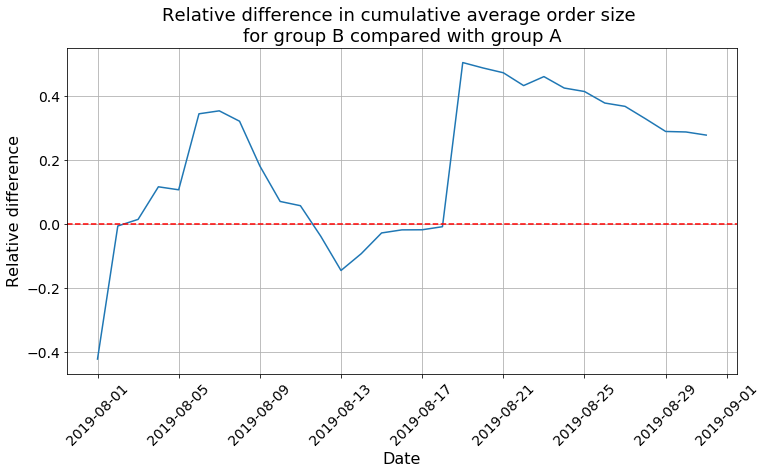

In [20]:
# Compute the relative difference in cumulative average order
rel_diff_cum_avg_order_size = cum_avg_order_size_pivot['B']/cum_avg_order_size_pivot['A'] - 1
display(rel_diff_cum_avg_order_size.to_frame(name='relative_diff'))

# Plot the relative difference in cumulative average order
plt.figure(figsize=(12, 6))
plt.plot(rel_diff_cum_avg_order_size.index, rel_diff_cum_avg_order_size)

plt.title('Relative difference in cumulative average order size \n'
          'for group B compared with group A', fontsize=18)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Relative difference', fontsize=16) 
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.grid()

# adding a horizontal axis with the axhline() method
plt.axhline(y=0, color='red', linestyle='--')
plt.show()


We observe spikes at several points in the difference between the groups. The location of the spikes indeed match the locations of the surges we observed in the average order size of group B. These spikes hint on the presence of some big orders and outliers, which we will find later.

**Group's conversion rates:** We calculate and plot both each group's daily and cumulative conversion rates, as well as the relative conversion rate of group B compared with group A. The convertion rate is computed by taking the ratio of orders to the number of visits. 

group,A,B
date,,
2019-08-01,0.032033,0.023977
2019-08-02,0.030744,0.039655
2019-08-03,0.047525,0.027778
2019-08-04,0.015406,0.018253
2019-08-05,0.029178,0.029830
2019-08-06,0.022659,0.035222
2019-08-07,0.024883,0.032532
2019-08-08,0.023140,0.033898
2019-08-09,0.018003,0.031199


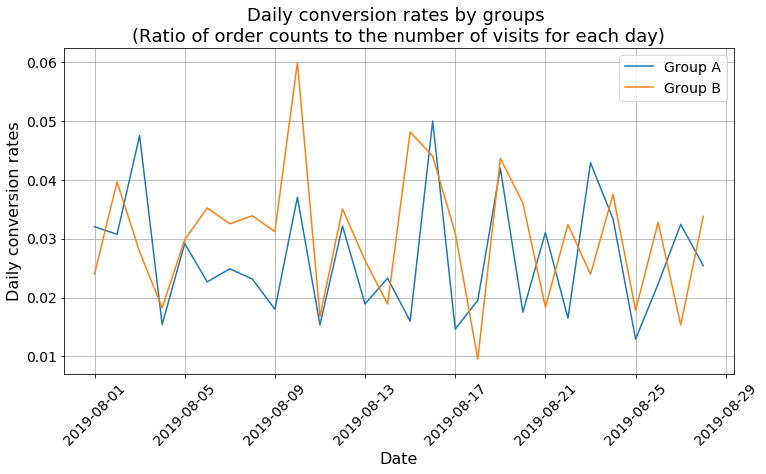

In [21]:
# Create a pivot table to display the number of visits from each group on each date 
visits_pivot = pd.pivot_table(index='date', columns='group', 
                                     values='visits',
                                     data=visits_cleaned)
# display(visits_pivot)

# Compute the cumulative number of visits from the pivot table
cum_visits_pivot = visits_pivot.cumsum()
# display(cum_visits_pivot)

# Compute the conversion rate from the visits and order_count pivot tables
conversion_rate_pivot = order_count_pivot/visits_pivot
display(conversion_rate_pivot)

# Plot each groups' conversion rate on the same graph
plt.figure(figsize=(12, 6))

# Plot the conversion rate of group A
plt.plot(conversion_rate_pivot.index, conversion_rate_pivot['A'], label='Group A')
# Plot the conversion rate of group B
plt.plot(conversion_rate_pivot.index, conversion_rate_pivot['B'], label='Group B')

plt.title('Daily conversion rates by groups \n'
          '(Ratio of order counts to the number of visits for each day)', fontsize=18)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Daily conversion rates', fontsize=16)
plt.legend(fontsize=14)
plt.grid()
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.show()


The daily conversion rates of both groups fluctuate strongly throughout the entire month. Thus, it is hard to compare the performance of the groups with each other.

group,A,B
date,,
2019-08-01,0.032033,0.023977
2019-08-02,0.031437,0.031032
2019-08-03,0.035850,0.030117
2019-08-04,0.030137,0.026562
2019-08-05,0.029918,0.027267
2019-08-06,0.028708,0.028593
2019-08-07,0.028175,0.029196
2019-08-08,0.027591,0.029774
2019-08-09,0.026587,0.029922


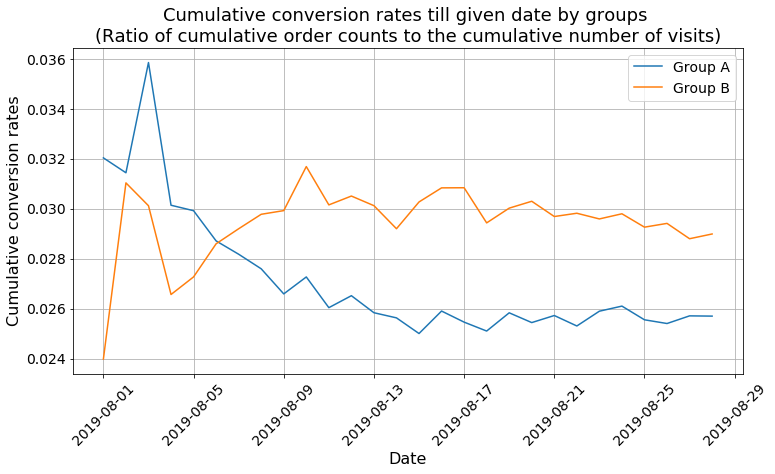

In [22]:
# Compute the cumulative conversion rates from the cumulative visits and cumulative order_count pivot tables.
# cum_conversion_rate_pivot = cum_visits_pivot/cum_order_count_pivot
cum_conversion_rate_pivot = cum_order_count_pivot/cum_visits_pivot
display(cum_conversion_rate_pivot)

# Plot each groups' cumulative conversion rate on the same graph
plt.figure(figsize=(12, 6))

# Plot the cumulative conversion rate of group A
plt.plot(cum_conversion_rate_pivot.index, cum_conversion_rate_pivot['A'], label='Group A')
# Plot the cumulative conversion rate of group B
plt.plot(cum_conversion_rate_pivot.index, cum_conversion_rate_pivot['B'], label='Group B')

plt.title('Cumulative conversion rates till given date by groups \n'
          '(Ratio of cumulative order counts to the cumulative number of visits)', fontsize=18)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Cumulative conversion rates', fontsize=16)
plt.legend(fontsize=14)
plt.grid()
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.show()


As opposed to the daily conversion rates, the cumulative conversion rates fluctuates strongly only in the first few days of the month. After the first few days, the conversion rate of group B rose and stabilizes around the band of 2.8% to 3%, while the conversion rates of group B drops and stabilizes just below the threshold of 2.6%.

,relative_diff
date,
2019-08-01,-0.251487
2019-08-02,-0.012893
2019-08-03,-0.159915
2019-08-04,-0.118608
2019-08-05,-0.088616
2019-08-06,-0.004000
2019-08-07,0.036216
2019-08-08,0.079112
2019-08-09,0.125446


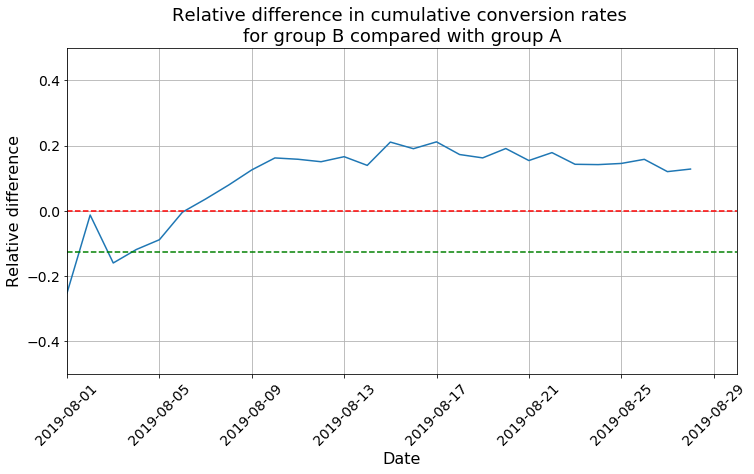

In [23]:
# Compute the relative difference for the cumulative conversion rates

rel_diff_cum_conversion_rate = cum_conversion_rate_pivot['B']/cum_conversion_rate_pivot['A'] - 1
display(rel_diff_cum_conversion_rate.to_frame(name='relative_diff'))

# Plot the relative difference for the cumulative conversion rates
plt.figure(figsize=(12, 6))
plt.plot(rel_diff_cum_conversion_rate.index, rel_diff_cum_conversion_rate)

plt.title('Relative difference in cumulative conversion rates \n'
          'for group B compared with group A', fontsize=18)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Relative difference', fontsize=16) 
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.grid()

# adding a horizontal axis with the axhline() method
plt.axhline(y=0, color='red', linestyle='--')
plt.axhline(y=-0.126, color='green', linestyle='--')

plt.axis([dt.datetime.strptime('2019-08-01', '%Y-%m-%d'), 
          dt.datetime.strptime('2019-08-30', '%Y-%m-%d'), -0.5, 0.5])
plt.show()


Until the 7th day of the test, group B was lagging behind group A in terms of conversion rate, but the conversion rate of group A kept falling (except a surge in the third day). Then, group B took the lead and the conversion rate of group A continued to drop until the 10th day of the month. After that the conversion ratio seems to have stabilized. Nevertheless, before drawing conclusions about the test, we should study more closely the outliers and their impact on the test results. 

#### Step 2.3 Outlier analysis in orders and prices <a class="anchor" id="step2_3"></a>  

In this step we study the outliers in the number of orders per visitors and the order prices. In particular, we identify the 95th and 99th percentiles to define the thresholds from which onward data points can be treated as anomalies. For the analysis, we use the original dataset (without visitors in both groups removed). 

**Number of orders per user:** 

In [24]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B


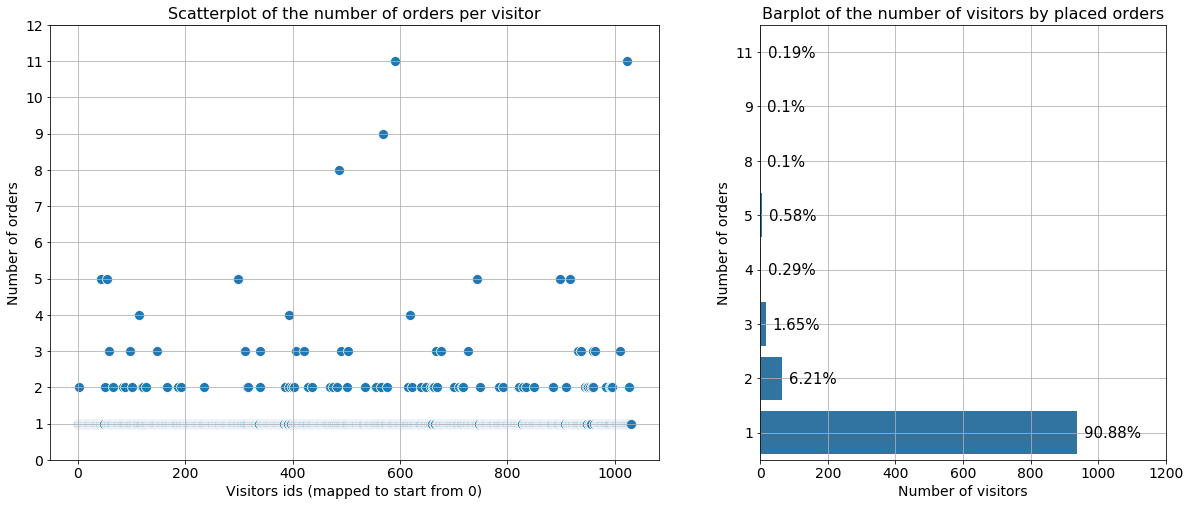

The 95th and 99th percentiles for the number of orders per user are: [2. 4.]


In [25]:
# Compute the number of orders for each visitor.
orders_per_visitor = orders.groupby(by='visitorId').agg({'transactionId':'nunique'}).reset_index()
orders_per_visitor = orders_per_visitor.sort_values(by='transactionId')
# display(orders_per_visitor.head())

# Show scatter plot of the number of orders per visitors
fig, ax = plt.subplots(1, 2, figsize=(20,8), gridspec_kw={'width_ratios': [1.5, 1]})

x_values = pd.Series(range(0, len(orders_per_visitor['transactionId'])))
sns.scatterplot(x_values, orders_per_visitor['transactionId'], s = 100, ax = ax[0])
ax[0].set_title('Scatterplot of the number of orders per visitor', fontsize=16)
ax[0].set_xlabel('Visitors ids (mapped to start from 0)', fontsize=14)
ax[0].set_ylabel('Number of orders', fontsize=14)
ax[0].tick_params(axis='both', labelsize=14)
ax[0].grid()
ax[0].set_yticks(range(0, 13))
# Compute the number of visitors per number of orders.
visitors_per_orders = orders_per_visitor.groupby(by='transactionId').agg({'visitorId':'count'}).reset_index()
# display(visitors_per_orders)

# Show barplot of the number of orders per visitors
sns.barplot(y='transactionId', x='visitorId', data=visitors_per_orders, orient='h', color='C0', ax=ax[1])
ax[1].set_title('Barplot of the number of visitors by placed orders',
          fontsize=16)
ax[1].set_xlabel('Number of visitors', fontsize=14)
ax[1].set_ylabel('Number of orders', fontsize=14)
ax[1].tick_params(axis='both', labelsize=14)
ax[1].grid()
ax[1].invert_yaxis()
ax[1].set_xlim(right=1200)

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax[1].patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax[1].patches:
    # get_width pulls left or right; get_y pushes up or down
    ax[1].text(i.get_width()+20, i.get_y()+.3, \
            str(round((i.get_width()/total)*100, 2))+'%', fontsize=15,
color='black')

plt.show()

# Get the 95th and 99th percentiles using np.percentile() method
orders_per_visitor_perc = np.percentile(orders_per_visitor['transactionId'], [95, 99])

print('The 95th and 99th percentiles for the number of orders per user are:', 
      orders_per_visitor_perc) 


From the scatter plot, it is clear that most of the visitors placed only one orders. In fact, as the barplot shows, that amounts to almost 91% of the visitors. We can also see that about 6% places 2 orders and about 1.65% placed 3 orders. The remaining 1% of the visitors placed however up to 11 orders. The percentiles we found are also naturally in line with the observed behavior: nearly 95% of the time, visitors placed less than 2 orders, and nearly 99% ıf the time, they placed less than 4 orders. We can thus consider visitors who placed more than 3 orders as exceptional cases.

**Order prices:**

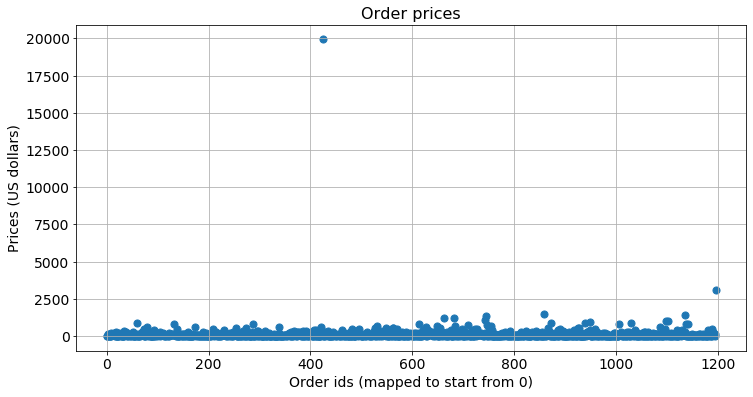

In [26]:
# Show scatter plot of the orders prices
plt.figure(figsize=(12,6))
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'], s = 50)
plt.title('Order prices', fontsize=16)
plt.xlabel('Order ids (mapped to start from 0)', fontsize=14)
plt.ylabel('Prices (US dollars)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.show()


As in the case of the number of orders per visitors, there are also exceptional cases in the revenues generated from some orders. In fact, we had already observed this in the data preprocessing step. As it is not very clear from the plot what happens for orders whose revenues are below 2500 US dollars, let us replot the scatter plot setting the y-axis limit to that threshold. We also compute the perentiles. 

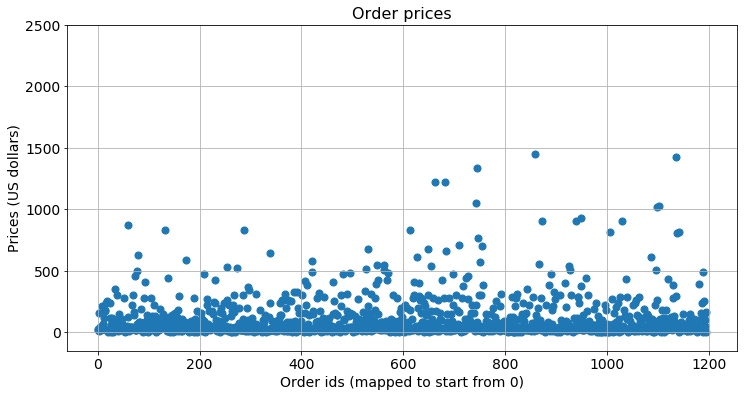

The 95th and 99th percentiles of order prices are 436 and 901 US dollars


In [27]:
# Show scatter plot of the order prices for up to 2500 US dollars
plt.figure(figsize=(12,6))
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'], s = 50)

plt.title('Order prices', fontsize=16)
plt.xlabel('Order ids (mapped to start from 0)', fontsize=14)
plt.ylabel('Prices (US dollars)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(top=2500)
plt.ylim(bottom=-150)
plt.grid()
plt.show()

# Get the 95th and 99th percentiles using np.percentile() method
order_prices_perc = np.percentile(orders['revenue'], [95, 99]).round(0).astype('int')

print('The 95th and 99th percentiles of order prices are {} and {} US dollars'.format(
      order_prices_perc[0], order_prices_perc[1]))

Now we observe that the revenue from the majority of the orders remained below 1000 US dollars. In fact, the 99th percentile is returned as approximately 901 US dollars. To remove the outliers, we will later need to identify the visitor ids of those users whose number of orders and/or order prices do not fall within the "expected" typical range. Based on the graphs and percentiles we found, let us defined the typical range as follows: up to and including 3 orders per visitors and up to and including 1000 US dollars per orders. Thus, a data point is treated as an anomaly either when visitors placed 4 or more orders or when the price of an order exceeded 1000 US dollars. 

#### Step 2.4 Statistical significance of the difference in performance between groups <a class="anchor" id="step2_4"></a>  

In this step we analyse the statistical significance of the difference in conversion rates and order sizes between group A and group B. We first carry out the computations using raw data. Then, we repeat the same computations with data in which the outlier values (based on the 99th percentile values we identified in the previous step) are removed. In testing the hypothesis of equal proportions for our groups' performance 

Here we used the cleaned datasets (with visitors assigned to both groups removed).

**Statistical significance of the difference in conversion rates and order sizes with raw data:**

We first find the aforementioned statistical significances with raw data.

In [28]:
ordersByUsersA = (orders_cleaned.loc[orders_cleaned['group']=='A']
                  .groupby('visitorId', as_index=False)
                  .agg({'transactionId' : pd.Series.nunique}))

ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = (orders_cleaned.loc[orders_cleaned['group']=='B']
                  .groupby('visitorId', as_index=False)
                  .agg({'transactionId' : pd.Series.nunique}))
ordersByUsersB.columns = ['visitorId', 'orders']

sampleA = pd.concat([ordersByUsersA['orders'],
                     pd.Series(0, index=np.arange(
                         visits_cleaned[visits_cleaned['group']=='A']['visits'].sum() 
                         - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],
                     pd.Series(0, index=np.arange(
                         visits_cleaned[visits_cleaned['group']=='B']['visits'].sum() 
                         - len(ordersByUsersB['orders'])), name='orders')],axis=0)


We have gathered the data we need to test the hypotheses. We formulate the null and alternative hypotheses as follows:
- **Null Hypothesis:** There isn't a statistically significant difference in conversion rates between the group A and group B.
- **Alternative Hypothesis:** The difference in conversion rates of the groups A and B are statistically significant. 

In [29]:
print("The relative conversion gain for group B is {0:.3f}.".format(sampleB.mean()/sampleA.mean()-1)) 


p_value = st.mannwhitneyu(sampleA, sampleB)[1]
print("p-value of Wilcoxon-Mann-Whitney non-parametric test for convertion rate samples is {0:.3f}".format(p_value))

alpha = 0.05
if (p_value < alpha):
    print("Rejecting the null hypothesis: there is a significant difference between the groups' convertion rates.")
else:
    print("Failed to reject the null hypothesis: we can't make conclusions about the difference in " 
          "the groups' convertion rates.") 


The relative conversion gain for group B is 0.158.
p-value of Wilcoxon-Mann-Whitney non-parametric test for convertion rate samples is 0.006
Rejecting the null hypothesis: there is a significant difference between the groups' convertion rates.


The relative gain in convertion rate of group B is 16%. Moreover, based on the p-value of 0.006, which is smaller than 0.05, we can reject the null hypothesis that there's not a statistically significant difference in conversion between the groups.

Let us check what happens for order sizes.

This time, we formulate the null and alternative hypotheses as follows:
- **Null Hypothesis:** There isn't a statistically significant difference in order sizes between the groups A and B.
- **Alternative Hypothesis:** The difference between order sizes of the groups A and B are statistically significant. 

In [30]:
print('The relative order size for group B is {0:.3f}.'.format(
    orders_cleaned[orders_cleaned['group']=='B']['revenue'].mean()
    /orders_cleaned[orders_cleaned['group']=='A']['revenue'].mean()-1))

p_value = (st.mannwhitneyu(orders_cleaned[orders_cleaned['group']=='A']['revenue'], 
                                       orders_cleaned[orders_cleaned['group']=='B']['revenue'])[1])

print("p-value of Wilcoxon-Mann-Whitney non-parametric test for order size samples is {0:.3f}".format(p_value))

alpha = 0.05
if (p_value < alpha):
    print("Rejecting the null hypothesis: there is a significant difference between the groups' order sizes.")
else:
    print("Failed to reject the null hypothesis: we can't make conclusions about the difference in "
          "the groups' order sizes.") 


The relative order size for group B is 0.278.
p-value of Wilcoxon-Mann-Whitney non-parametric test for order size samples is 0.431
Failed to reject the null hypothesis: we can't make conclusions about the difference in the groups' order sizes.


The average order size for group B is much larger than the one for group A. However, since the p-value of 0.431 is much larger than the threshold 0.05, we can't reject the null hypothesis. We thus cannot conclude that there is a statistically significant difference in the groups' order sizes. 

Based on the hypothesis tests we carried out with raw data, we cannot decide yet if the performed A/B test was successful or not. Let us see if removing the outliers will clarify the picture.

**Statistical significance of the difference in conversion rates and order sizes with filtered data:**

Here, we will redo the statistical significance computations, but this time leaving out the outliers in data. Recall that we have identified in the previous step the 99th percentile of the number of orders per visitors as 4 and the 99th percentile of the order prices as 901 US dollars. 

To remove the outliers, we need to find the visitor ids of those users whose number of orders and/or order prices do not fall within the "expected" typical range. Recall that we defined the typical range as follows: up to and including 3 orders per visitors and up to and including 1000 US dollars per orders. Therefore, we will filter out from raw data the visitors who placed 4 or more orders and/or whose order price is more than 1000 US dollars. Below, we identify the visitor ids of such visitors.

In [31]:
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 4]['visitorId'], 
                                 ordersByUsersB[ordersByUsersB['orders'] > 4]['visitorId']], axis = 0)
usersWithExpensiveOrders = orders[orders['revenue'] > 1000]['visitorId']
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()
print('The following {} visitors displayed atypical behaviors in their number of orders and order prices behavior:'
      .format(abnormalUsers.shape[0]))
print(abnormalUsers)


The following 9 visitors displayed atypical behaviors in their number of orders and order prices behavior:
1099     148427295
744      888512513
1103    1164614297
1136    1307669133
858     1316129916
425     1920142716
1196    2108080724
743     4133034833
662     4266935830
Name: visitorId, dtype: int64


In [32]:
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['visitorId']
                                                           .isin(abnormalUsers))]['orders'],
                             pd.Series(0, index=np.arange(
                                 visits_cleaned[visits_cleaned['group']=='A']['visits'].sum() 
                                 - len(ordersByUsersA['orders'])),name='orders')],axis=0)

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['visitorId']
                                                           .isin(abnormalUsers))]['orders'],
                             pd.Series(0, index=np.arange(
                                 visits_cleaned[visits_cleaned['group']=='B']['visits'].sum()
                                 - len(ordersByUsersB['orders'])),name='orders')],axis=0)


We have filtered anomalies from raw data and now we will test our hypotheses again. As before we first test the following null and alternative hypotheses:
- **Null Hypothesis:** There isn't a statistically significant difference in conversion rates between the groups A and  B (based on filtered data).
- **Alternative Hypothesis:** The difference in conversion rates of the groups A and B are statistically significant (based on filtered data). 

In [33]:
print("The relative conversion gain for group B is {0:.3f}.".format(sampleAFiltered.mean()/sampleBFiltered.mean()-1)) 


p_value = st.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]
print("p-value of Wilcoxon-Mann-Whitney non-parametric test for convertion rate samples is {0:.3f}".format(p_value))

alpha = 0.05
if (p_value < alpha):
    print("Rejecting the null hypothesis: there is a significant difference between the groups' convertion rates.")
else:
    print("Failed to reject the null hypothesis: we can't make conclusions about the difference in " 
          "the groups' convertion rates.") 


The relative conversion gain for group B is -0.139.
p-value of Wilcoxon-Mann-Whitney non-parametric test for convertion rate samples is 0.005
Rejecting the null hypothesis: there is a significant difference between the groups' convertion rates.


After filtering out the anomalies, the previously found relative gain of 16% for group B in convertion rate changed to a relative loss of 14%. Nevertheless, our conclusion about the statistical significance in differences in convertion rates did not change. We can still reject the null hypothesis and conclude that there is a difference in the groups's convertion rates. Let us also check how the results for order size are affected.

This time we test the following null and alternative hypotheses:
- **Null Hypothesis:** There isn't a statistically significant difference in order sizes between the groups A and B (based on filtered data).
- **Alternative Hypothesis:** The difference between order sizes of the group A and group B are statistically significant (based on filtered data).  

In [34]:
print('The relative order size for group B is {0:.3f}.'.format(
    orders[np.logical_and(orders['group']=='B',
                          np.logical_not(orders['visitorId']
                                         .isin(abnormalUsers)))]['revenue'].mean()/
    orders[np.logical_and(orders['group']=='A',
                          np.logical_not(orders['visitorId']
                                         .isin(abnormalUsers)))]['revenue'].mean() - 1))

p_value = (st.mannwhitneyu(
    orders_cleaned[np.logical_and(
        orders_cleaned['group']=='A',
        np.logical_not(orders_cleaned['visitorId'].isin(abnormalUsers)))]['revenue'],
    orders_cleaned[np.logical_and(
        orders_cleaned['group']=='B',
        np.logical_not(orders_cleaned['visitorId'].isin(abnormalUsers)))]['revenue'])[1])

print("p-value of Wilcoxon-Mann-Whitney non-parametric test for order size samples is {0:.3f}".format(p_value))

alpha = 0.05
if (p_value < alpha):
    print("Rejecting the null hypothesis: there is a significant difference between the groups' order sizes.")
else:
    print("Failed to reject the null hypothesis: we can't make conclusions about the difference in "
          "the groups' order sizes.") 


The relative order size for group B is 0.017.
p-value of Wilcoxon-Mann-Whitney non-parametric test for order size samples is 0.464
Failed to reject the null hypothesis: we can't make conclusions about the difference in the groups' order sizes.


The average order size for group B is now only slightly larger than the one for group A. As for the convertion rates, our conclusion about the difference in order sizes for the groups did also not change. Based on filtered data, we still cannot reject the null hypothesis. Thus, we conclude that there is no difference in the group's order sizes. 

<a class="anchor" id="step3"></a> 
### Step 3. General Conclusions

In this project, we first prioritized hypotheses for an A/B test. We prioritized the hypotheses based on the ICE and RICE frameworks. We found out that the list of the top priority hypotheses depends on the scoring framework used. Then in several steps, we proceeded with the analysis of the results of a launched A/B test over the period of a month. Here are the conclusions we can draw from this test:
- Both raw and filtered data revealed that there is a statistically significant difference in the conversion rates between the groups.
- Actually, the plotted difference in conversion between the groups shows us that group B is the leader at the end of the test and the results seem to have stabilized.
- However, neither raw nor filtered data revealed any statistically significant difference in the average order sizes between the groups.
- In addition, the plotted difference in average order size between the groups shows us that group B's results are steadily worsening even if they are currently about 30% better than group A's results. In fact, after removing large outliers for order prices, the average order sizes of both groups became almost equal.  

**Decision about the success of the A/B test:** Based on the above facts, we conclude that the test can be stopped. 
Although at the end of the test, we have not identified the existence of a statistically significant difference in the average revenues generated between the orders of both groups, group B is clearly more successful in converting visitors to buyers. As the probability that group A will become better than group B is extremely low, there's no use in continuing the test. We can declare group B as the leader. 